In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import networkx as nx

In [3]:
N=200
g = nx.barabasi_albert_graph(N,1)
A = nx.to_numpy_array(g)

In [4]:
def LV(x,t,A,a,b):
    N = x.shape[0]
    dXdt = np.zeros(N)
    for n in range(0,N):
        dXdt[n] = x[n]*(a[n]-b[n]*x[n])
        for j in range(0,N):
            dXdt[n] -= A[n,j]*x[n]*x[j]
    return dXdt

In [61]:
x0 = np.random.uniform(0,1,N)
T = 5
dt = 0.05
nT = int(T/dt) 
t = np.linspace(0,T,nT)
a = np.random.uniform(0.5,1.5,N)
b = np.random.uniform(0.5,1.5,N)
x = sp.integrate.odeint(LV,x0,t,args=(A,a,b,))
ratio = 0.5
t_obs = T*ratio
nT_obs = int(T*ratio/dt)

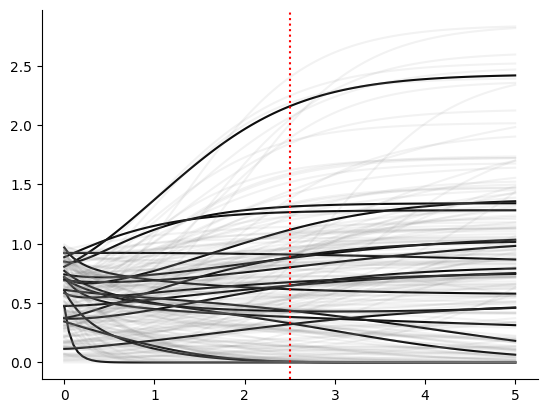

In [55]:
for n in range(0,20):
    plt.plot(t,x[:,n*10],'black')
for n in range(0,N):
    plt.plot(t,x[:,n],'grey',alpha=0.1)
plt.axvline(t_obs,c='red',linestyle=':')
sns.despine()
data = torch.tensor(x[:nT_obs,:], dtype=torch.float32)

In [56]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,input_dim),
            nn.ReLU(True),
            nn.Linear(input_dim,latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.ReLU(True),
            nn.Linear(input_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [65]:
input_dim = 200  # Replace N with the actual input dimension
latent_dim = 100  # Replace M with the desired latent space dimension

model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 10
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

# Example training loop
num_epochs = 200
for epoch in range(num_epochs):
    
    for batch in data_loader:
        # Forward pass
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    if np.mod(epoch+1,100)==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/200], Loss: 0.0017
Epoch [200/200], Loss: 0.0001


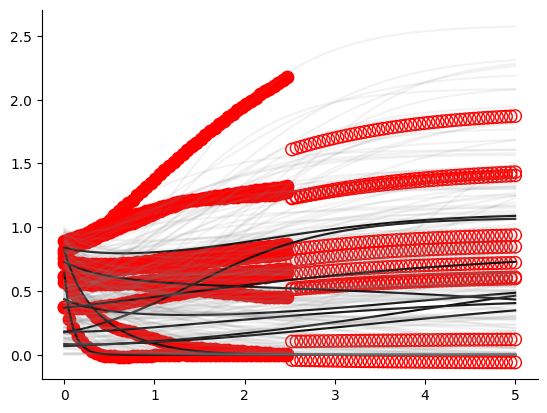

In [66]:
embedded,reconstructed = model(data)
embedded = embedded.detach().numpy()
reconstructed = reconstructed.detach().numpy()

unseen = torch.tensor(x[nT_obs:,:], dtype=torch.float32)
unseen_embedded, unseen_reconstructed = model(unseen)
unseen_embedded = unseen_embedded.detach().numpy()
unseen_reconstructed = unseen_reconstructed.detach().numpy()

for n in range(0,10):
    plt.plot(t,x[:,n*20],'black')
    plt.scatter(t[:nT_obs],reconstructed[:,n*20], s=80, color='r')
    plt.scatter(t[nT_obs:],unseen_reconstructed[:,n*20], s=80, edgecolor='r',facecolor='None')
for n in range(0,N):
    plt.plot(t,x[:,n],'grey',alpha=0.1)
#plt.axvline(t_obs,c='red',linestyle=':')
sns.despine()